# Transfer Learing: Fine Tuning

In [1]:
# Check if using a GPU
!nvidia-smi

Mon Jan 23 18:00:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating Helper Functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-23 18:00:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-23 18:00:58 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves
from helper_functions import unzip_data, walk_through_dir

## Getting the Data

In [4]:
# Get 10% of training data of 10 classes of food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-01-23 18:01:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   129MB/s    in 1.2s    

2023-01-23 18:01:04 (129 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check how many images and subdirectories are in the dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [6]:
# Create training and test directory paths
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [7]:
import tensorflow as tf

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Check the class names of the dataste
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See and example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.05775513e+02 7.17755127e+01 4.60612259e+01]
   [1.04790817e+02 6.98622437e+01 4.95051041e+01]
   [9.69336700e+01 6.16581612e+01 4.25816307e+01]
   ...
   [3.17908516e+01 4.07658815e+00 6.06119633e+00]
   [4.83164749e+01 1.26480646e+01 4.33680964e+00]
   [8.92354584e+01 4.72761917e+01 2.60771675e+01]]

  [[1.10260201e+02 7.64030609e+01 5.08316345e+01]
   [1.04877548e+02 7.01581650e+01 4.97448959e+01]
   [9.83163223e+01 6.33163261e+01 4.41020393e+01]
   ...
   [8.11636276e+01 3.58064613e+01 4.11231232e+00]
   [1.33173721e+02 8.34747086e+01 3.90562897e+01]
   [1.62270523e+02 1.09724571e+02 5.80612450e+01]]

  [[1.11556122e+02 7.95561218e+01 5.58418350e+01]
   [9.48826523e+01 6.21530571e+01 4.24693832e+01]
   [9.71683655e+01 6.34030609e+01 4.54234657e+01]
   ...
   [1.66954346e+02 1.11643112e+02 5.57194862e+01]
   [1.64392776e+02 1.10076469e+02 4.88009720e+01]
   [1.52413177e+02 1.03474449e+02 4.16071587e+01]]

  ...

  [[4.10560951e+01 1.28469152e+01 0.00000000e+00]
   [5

## Model 0: Building a Transfer Learning using the Keras Functional API

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using a model like ResNet50V2, normalize inputs required
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most 
# important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(
    name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, 
                                activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model and save it's history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(
                            dir_name='transfer_learning',
                            experiment_name='10_percent_feature_extraction'
                        )])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230123-180120
Epoch 1/5
24/24 [==============================] - 21s 254ms/step - loss: 1.9060 - accuracy: 0.4027 - val_loss: 1.3205 - val_accuracy: 0.7286
Epoch 2/5
24/24 [==============================] - 5s 183ms/step - loss: 1.1081 - accuracy: 0.7547 - val_loss: 0.8835 - val_accuracy: 0.8306
Epoch 3/5
24/24 [==============================] - 5s 182ms/step - loss: 0.7903 - accuracy: 0.8240 - val_loss: 0.6832 - val_accuracy: 0.8635
Epoch 4/5
24/24 [==============================] - 4s 147ms/step - loss: 0.6456 - accuracy: 0.8560 - val_loss: 0.6092 - val_accuracy: 0.8684
Epoch 5/5
24/24 [==============================] - 4s 149ms/step - loss: 0.5452 - accuracy: 0.8893 - val_loss: 0.5340 - val_accuracy: 0.8816


In [13]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.5626 - accuracy: 0.8620


[0.5626005530357361, 0.8619999885559082]

In [14]:
# Check the layers in the base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer)

0 <keras.engine.input_layer.InputLayer object at 0x7fdbbdebf7c0>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fdbbdebfeb0>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fdbbe013160>
3 <keras.layers.core.tf_op_layer.TFOpLambda object at 0x7fdbbe013820>
4 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fdbbe0135e0>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fdbbe013280>
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdbbe05fdf0>
7 <keras.layers.core.activation.Activation object at 0x7fdbbd20d6a0>
8 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fdbbd1c1550>
9 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fdbbdf95730>
10 <keras.layers.core.activation.Activation object at 0x7fdbbdf95d30>
11 <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fdbbd1f23d0>
12 <keras.layers.reshaping.

In [15]:
# Model summary
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
# Summary of the whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


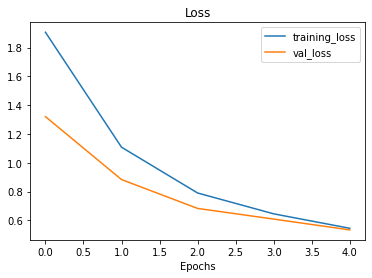

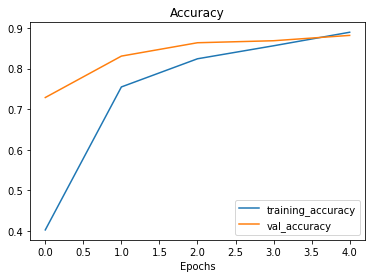

In [17]:
# Check the model's training curves
plot_loss_curves(history_0)

## Getting a Feature Vector from the Trained Model

In [18]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}\n')

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor:\n {global_average_pooled_tensor}\n')

# Check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Global Average Pooled 2D Tensor: {global_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D Tensor: (1, 3)


- Removes the two inner dimensions

In [19]:
# Replicating the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a Series of Transfer Learning Experiments

1. `model_1`: use feature extraction transfer learning with 1% of the training data with data augmentation

2. `model_2`: use feature extraction transfer learning with 10% of the training data with data augmentation

3. `model_3`: use fine-tuning transfer learning on 10% of the training data with data augmentation

4. `model_4`: use fine-tuning transfer learning on 100% of the training data with data augmentation

### Getting and Preprocessing Data for model_1

In [20]:
# Download and unzip data
! wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data('10_food_classes_1_percent.zip')

--2023-01-23 18:02:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 173.194.192.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  54.3MB/s    in 2.3s    

2023-01-23 18:02:12 (54.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
# Creating training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [22]:
# How many images are there?
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [23]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding Data Augmentation Right Into the Model

In [24]:
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [25]:
# Create data augmentation stage
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
], name='data_augmentation')

### Visualize the Data Augmentation Layer

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

10_food_classes_1_percent/train/steak
10_food_classes_1_percent/train/steak/612551.jpg


(-0.5, 573.5, 415.5, -0.5)

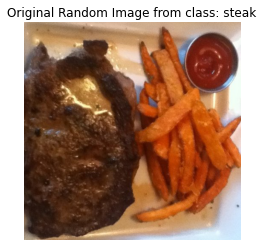

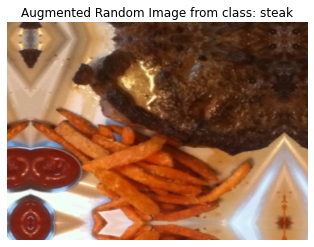

In [27]:
# View a random image and compare it to it's augmented version
target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
print(target_dir)
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image
print(random_image_path)

# Read in random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f'Original Random Image from class: {target_class}')
plt.axis(False)

# Plotting the augmented random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img / 255.)
plt.title(f'Augmented Random Image from class: {target_class}')
plt.axis(False)

### Model 1: Feature Extraction Transfer Learning on 1% of the Data with Data Augmentation

In [28]:
# Setup input shape and base model, freezing the base model layers
input_shape = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmented) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        # Track model training logs
                        callbacks=[create_tensorboard_callback(
                            dir_name='transfer_learning',
                            experiment_name='1_percent_data_aug'
                        )])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230123-180216
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.3846 - accuracy: 0.1143

3/3 [==============================] - 10s 2s/step - loss: 2.3846 - accuracy: 0.1143 - val_loss: 2.2275 - val_accuracy: 0.1842
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1635 - accuracy: 0.3000 - val_loss: 2.1134 - val_accuracy: 0.2484
Epoch 3/5
3/3 [==============================] - 6s 3s/step - loss: 2.0169 - accuracy: 0.3143 - val_loss: 1.9937 - val_accuracy: 0.2993
Epoch 4/5
3/3 [==============================] - 4s 1s/step - loss: 1.7360 - accuracy: 0.5857 - val_loss: 1.8856 - val_accuracy: 0.3964
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6079 - accuracy: 0.6714 - val_loss: 1.7809 - val_accuracy: 0.4704


In [29]:
# Check model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [30]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 71ms/step - loss: 1.7902 - accuracy: 0.4620


[1.7901538610458374, 0.4620000123977661]

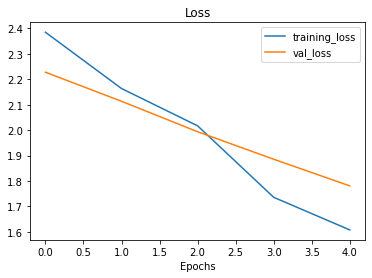

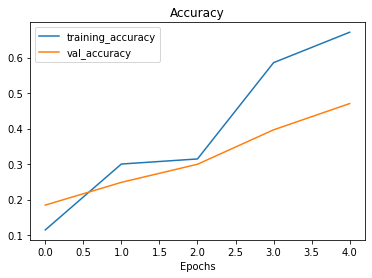

In [31]:
# Loss curves
plot_loss_curves(history_1)

## Model 2: Feature Extraction Transfer Learning Model with 10% of Data and Data Augmentation

In [32]:
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [33]:
# Set data inputs
IMG_SHAPE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode='categorical',
    image_size=IMG_SHAPE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SHAPE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [34]:
from keras.models import Sequential

In [35]:
# Create model 2 with data augmentation built in
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name='data_augmentation')

# Setup the input shape to the model
input_shape = IMG_SHAPE + (3,)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Creating a Model Checkpoint Callback

In [36]:
# Set checkpoint path
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch', # Save every epoch
    verbose=1
    )

### Fitting Model 2 Passing in the ModelCheckpoint Callback

In [37]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(
                            dir_name='transfer_learning',
                            experiment_name='10_percent_data_aug'
                        ), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230123-180646
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9717 - accuracy: 0.3707
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 516ms/step - loss: 1.9717 - accuracy: 0.3707 - val_loss: 1.4110 - val_accuracy: 0.6908
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2887 - accuracy: 0.7107
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 406ms/step - loss: 1.2887 - accuracy: 0.7107 - val_loss: 0.9571 - val_accuracy: 0.7878
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9847 - accuracy: 0.7600
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 432ms/step - loss: 0.9847 - accuracy: 0.7600 - val_loss: 0.7631 - val_accuracy: 0.8257
E

In [38]:
# Check model_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 75ms/step - loss: 0.6105 - accuracy: 0.8444


[0.6104655265808105, 0.8443999886512756]

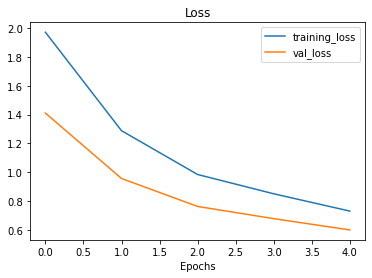

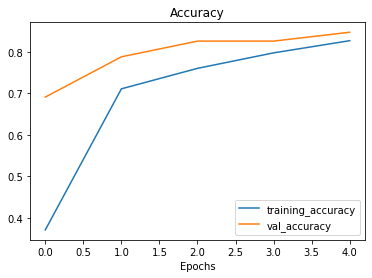

In [39]:
# Plot model's loss curves
plot_loss_curves(history_2)

### Loading in Checkpointed Weights

In [40]:
# Load in saved model weights and evaluate the model
model_2.load_weights(checkpoint_path)

In [41]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 0.6105 - accuracy: 0.8444


In [43]:
import numpy as np

In [44]:
# Checking to see if loaded model results are very close to the previous
# non-loaded model results
np.isclose(np.array(results_10_percent_data_aug), 
           np.array(loaded_weights_model_results))

array([ True,  True])

In [45]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


## Model 3: Fine-tuning an Existing Model on 10% of the Data

- Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data

In [46]:
# Layers in loaded model
model_2.layers

In [47]:
# Are these layers trainable?
for layer in model_2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fdb414e3b20> True
<keras.engine.sequential.Sequential object at 0x7fdb41755580> True
<keras.engine.functional.Functional object at 0x7fdb41490550> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fdb416fc580> True
<keras.layers.core.dense.Dense object at 0x7fdb3e196100> True


In [49]:
# What layers are in the base model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [50]:
# How many trainable variables are in the base model?
print(len(model_2.layers[2].trainable_variables))

0


In [53]:
# To begin fine-tuning, start by setting the last 10 layers
# base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (have to recompile every time changes are made)
model_2.compile(loss='categorical_crossentropy',
                # when fine-tuning, you tipically want to lower the learning
                # rate by 10x
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [55]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [57]:
# Now that some of the layers are unfrozen, how many
# trainable parameters are there?
print(len(model_2.trainable_variables))

12


In [58]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_tune_2 = model_2.fit(train_data_10_percent,
                                  epochs=fine_tune_epochs,
                                  validation_data=test_data,
                                  validation_steps=int(0.25 * len(test_data)),
                                  # Start training from previous last epoch
                                  initial_epoch=history_2.epoch[-1],
                                  callbacks=[create_tensorboard_callback(
                                      dir_name='transfer_learning',
                                      experiment_name='10_percent_fine_tune_last_10'
                                  )])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230123-185905
Epoch 5/10
24/24 [==============================] - 21s 566ms/step - loss: 0.6363 - accuracy: 0.8253 - val_loss: 0.4645 - val_accuracy: 0.8569
Epoch 6/10
24/24 [==============================] - 10s 388ms/step - loss: 0.5059 - accuracy: 0.8613 - val_loss: 0.4353 - val_accuracy: 0.8553
Epoch 7/10
24/24 [==============================] - 8s 323ms/step - loss: 0.4625 - accuracy: 0.8693 - val_loss: 0.4255 - val_accuracy: 0.8635
Epoch 8/10
24/24 [==============================] - 9s 358ms/step - loss: 0.3991 - accuracy: 0.8827 - val_loss: 0.3966 - val_accuracy: 0.8553
Epoch 9/10
24/24 [==============================] - 10s 388ms/step - loss: 0.3484 - accuracy: 0.9013 - val_loss: 0.3940 - val_accuracy: 0.8651
Epoch 10/10
24/24 [==============================] - 9s 352ms/step - loss: 0.3174 - accuracy: 0.9133 - val_loss: 0.3721 - val_accuracy: 0.8635


In [59]:
# Evaluate the fine-tuned model (model_3)
results_fine_tune_2 = model_2.evaluate(test_data)

79/79 [==============================] - 7s 78ms/step - loss: 0.4123 - accuracy: 0.8576


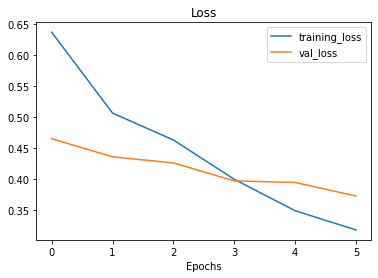

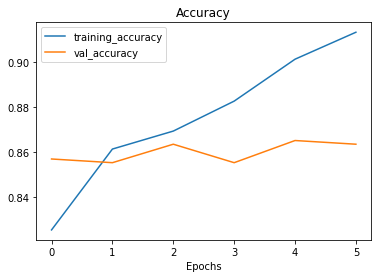

In [60]:
# Check the loss curves of the fine-tuned model
plot_loss_curves(history_fine_tune_2)

In [68]:
# Creating a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compare two TensorFlow History objects.
    """
    # Get original history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']

    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']

    # Combine original history
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']

    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']

    # Make plots for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), 
             label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Make plots for loss
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), 
             label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

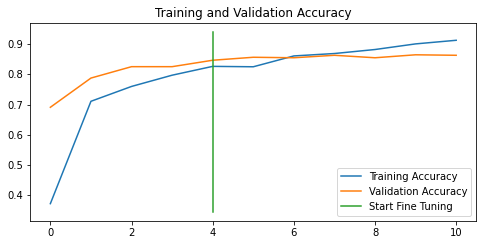

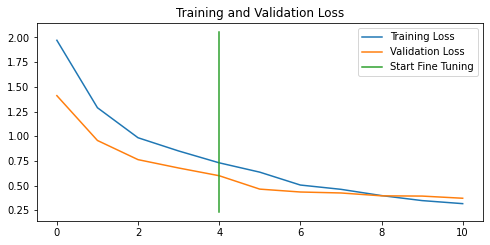

In [69]:
compare_histories(history_2,
                  history_fine_tune_2,
                  initial_epochs=5)

## Model 4: Fine-tuning an Existing Model on All of the Data

In [70]:
# Download and unzip all the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data('10_food_classes_all_data.zip')

--2023-01-23 19:23:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 142.250.103.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   197MB/s    in 2.5s    

2023-01-23 19:24:00 (197 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [71]:
# Setup training and test dirs
train_dir_all_data = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [72]:
# How many images?
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [74]:
# Setup data inputs
IMG_SHAPE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_all_data,
    label_mode='categorical',
    image_size=IMG_SHAPE
    )

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMG_SHAPE
    )

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [75]:
# Evaluate model 2
model_2.evaluate(test_data)

79/79 [==============================] - 7s 76ms/step - loss: 0.4123 - accuracy: 0.8576


[0.41228798031806946, 0.8575999736785889]

In [76]:
results_fine_tune_2

[0.41228795051574707, 0.8575999736785889]

### Reverting Model 2 back to the Feature Extraction Version

- To train a fine-tuning, model_2 needs it's feature extraction weights back

In [77]:
# Load weights from checkpoint
model_2.load_weights(checkpoint_path)

In [78]:
# Evaluate model 2
model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.6105 - accuracy: 0.8444


[0.6104656457901001, 0.8443999886512756]

In [79]:
# Check to see if model 2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6104655265808105, 0.8443999886512756]

In [80]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [81]:
# Check the base_model (EfficientNetB0) to see which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [82]:
# Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])

In [87]:
# Continue to train and fine-tune the model to the data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_tune_10_classes_full = model_2.fit(train_data_10_classes_full,
                                  epochs=fine_tune_epochs,
                                  validation_data=test_data,
                                  validation_steps=int(0.25 * len(test_data)),
                                  initial_epoch=history_2.epoch[-1],
                                  callbacks=[create_tensorboard_callback(
                                      dir_name='transfer_learning',
                                      experiment_name='full_10_classes_fine_tune_last_10'
                                  )])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230123-195529
Epoch 5/10
235/235 [==============================] - 57s 242ms/step - loss: 0.4884 - accuracy: 0.8444 - val_loss: 0.2449 - val_accuracy: 0.9243
Epoch 6/10
235/235 [==============================] - 52s 217ms/step - loss: 0.3781 - accuracy: 0.8747 - val_loss: 0.2367 - val_accuracy: 0.9211
Epoch 7/10
235/235 [==============================] - 46s 195ms/step - loss: 0.3065 - accuracy: 0.8972 - val_loss: 0.2445 - val_accuracy: 0.9145
Epoch 8/10
235/235 [==============================] - 55s 232ms/step - loss: 0.2609 - accuracy: 0.9139 - val_loss: 0.2176 - val_accuracy: 0.9227
Epoch 9/10
235/235 [==============================] - 53s 224ms/step - loss: 0.2104 - accuracy: 0.9297 - val_loss: 0.2230 - val_accuracy: 0.9293
Epoch 10/10
235/235 [==============================] - 43s 180ms/step - loss: 0.1946 - accuracy: 0.9340 - val_loss: 0.2147 - val_accuracy: 0.9342


In [88]:
# Evluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 72ms/step - loss: 0.3028 - accuracy: 0.9104


[0.302846223115921, 0.9103999733924866]

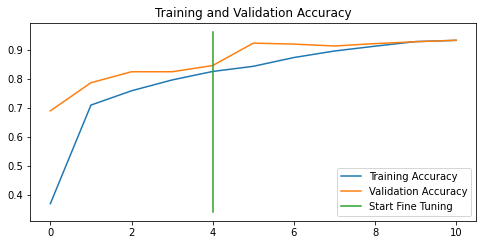

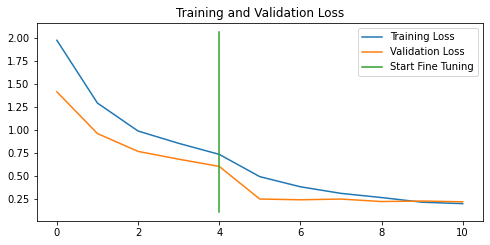

In [89]:
# How did fine-tuning go with more data?
compare_histories(original_history=history_2,
                  new_history=history_fine_tune_10_classes_full,
                  initial_epochs=5)

## Viewing the Experiment Data on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
    --name "Transfer Learning Experiments with 10 Food101 Classes" \
    --description "A series of different transfer learning experiments with \
    varying amounts of data and fine-tuning." \
    --one_shot

- TensorBoard Experiment Available at: https://tensorboard.dev/experiment/Se0GSduPSqGBlnB6YcmLLw/#scalars